In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import arviz as az

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
az.style.use('arviz-darkgrid')

# Synthetic Data

In [4]:
np.random.seed(42)
true_mean = 10
data = np.random.normal(true_mean, 2, 200)
data

array([10.99342831,  9.7234714 , 11.29537708, 13.04605971,  9.53169325,
        9.53172609, 13.15842563, 11.53486946,  9.06105123, 11.08512009,
        9.07316461,  9.06854049, 10.48392454,  6.17343951,  6.55016433,
        8.87542494,  7.97433776, 10.62849467,  8.18395185,  7.1753926 ,
       12.93129754,  9.5484474 , 10.13505641,  7.15050363,  8.91123455,
       10.22184518,  7.69801285, 10.75139604,  8.79872262,  9.4166125 ,
        8.79658678, 13.70455637,  9.97300555,  7.88457814, 11.64508982,
        7.5583127 , 10.41772719,  6.08065975,  7.3436279 , 10.39372247,
       11.47693316, 10.34273656,  9.76870344,  9.39779261,  7.04295602,
        8.56031158,  9.07872246, 12.11424445, 10.68723658,  6.47391969,
       10.64816794,  9.22983544,  8.646156  , 11.22335258, 12.06199904,
       11.86256024,  8.32156495,  9.38157525, 10.66252686, 11.95109025,
        9.04165152,  9.62868205,  7.78733005,  7.60758675, 11.62505164,
       12.71248006,  9.85597976, 12.0070658 , 10.72327205,  8.70

In [5]:
with pm.Model() as model:
    mean = pm.Normal('mean', mu=0, sd=10)
    sd = pm.HalfNormal('sd', 2)
    obs = pm.Normal('obs', mu=mean, sd=sd, observed=data)
    trace = pm.sample(1000, tune=1000)

e:\Anaconda\envs\pm3bap\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 49 seconds.
e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [6]:
with model:
    ppc = pm.sample_posterior_predictive(trace, samples=100, model=model)

e:\Anaconda\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


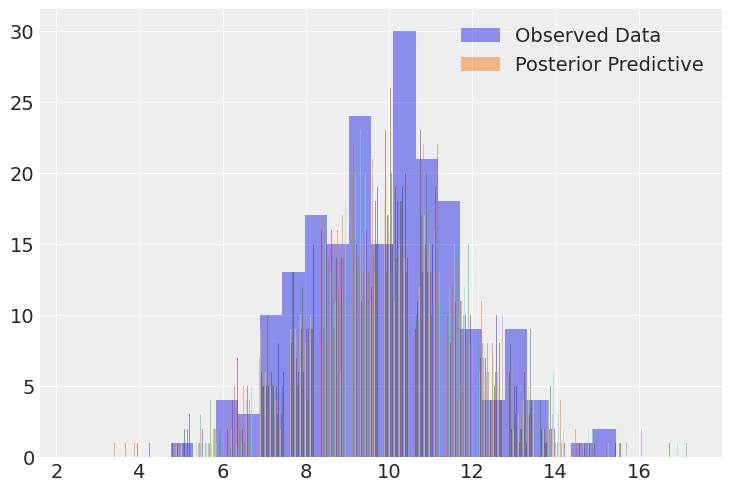

In [7]:
plt.hist(data,bins=20,alpha=0.5,label='Observed Data')
plt.hist(ppc['obs'], bins=20,alpha=0.5,label='Posterior Predictive')
plt.legend()
plt.show()

In [9]:
obs_statistic = np.mean(data)
ppc_statistic = np.mean(ppc['obs'], axis=0)

bayesian_p_value = np.mean(ppc_statistic >= obs_statistic)

print("bayesian_p_value: ", bayesian_p_value)

bayesian_p_value:  0.545


# Dummy Dataset

In [12]:
dummy_data = np.loadtxt('dummy.csv')
x_1 = dummy_data[:,0]
y_1 = dummy_data[:,1]

x_1
y_1

array([ 9.357,  8.322,  8.745,  7.346,  7.028,  4.032,  1.49 ,  3.265,
        4.525,  3.339,  2.045, -1.336,  1.264, -0.813, -0.335,  0.152,
       -1.797, -4.772, -3.043, -5.293, -4.401, -5.294, -2.912, -3.68 ,
       -3.975, -7.202, -4.317, -7.854, -5.167, -5.135, -6.754, -6.662,
       -6.08 ])

In [16]:
order=2
x_1p = np.vstack([x_1**i for i in range(1,order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True))/x_1p.std(axis=1, keepdims=True)
y_1s = (y_1-y_1.mean()) / y_1.std()


## Plot The Data

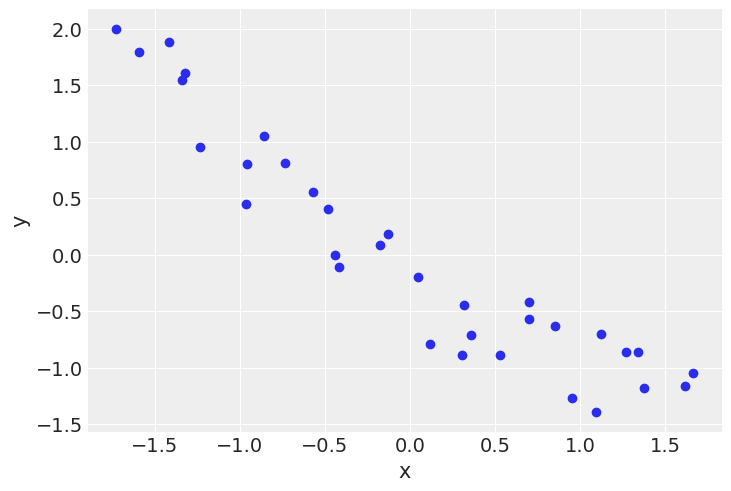

In [17]:
plt.scatter(x_1s[0],y_1s)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig('dummy.png',dpi=300)

## Linear Model

In [22]:
with pm.Model() as model_l:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', 5)
    mu = alpha + (beta*x_1s[0])
    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y_1s)
    idata_l = pm.sample(2000,return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 33 seconds.


## Polynomial Order of order 2

In [24]:
with pm.Model() as model_p:
    alpha = pm.Normal('alpha', mu=0, sd=1)
    beta = pm.Normal('beta', mu=0, sd=10, shape = order)
    sigma = pm.HalfNormal('sigma', 5)
    mu = alpha + pm.math.dot(beta, x_1s)
    y_pred = pm.Normal('y_pred', mu=mu, sd=sigma, observed=y_1s)
    idata_p = pm.sample(2000,return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


## Plotting and Comparing the Posterior of the Two Models

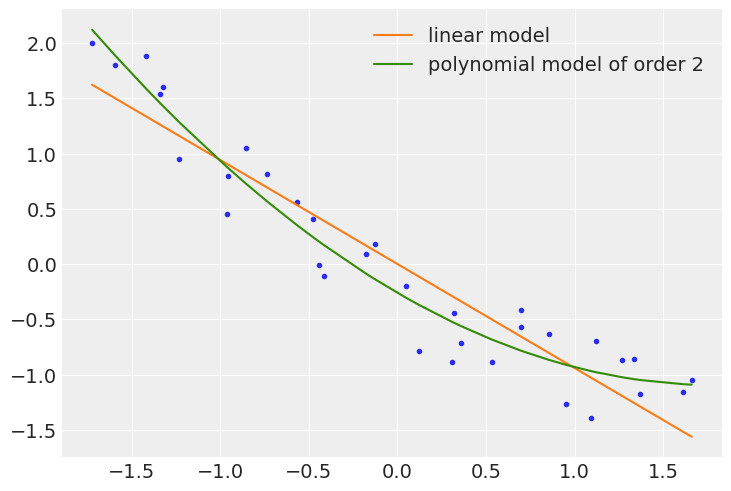

In [31]:
x_new = np.linspace(x_1s[0].min(),x_1s[0].max(),100)

a_l_post = idata_l.posterior['alpha'].mean(("chain","draw")).values
b_l_post = idata_l.posterior['beta'].mean(("chain","draw")).values
y_l_post = a_l_post + b_l_post*x_new

plt.plot(x_new,y_l_post,'C1',label='linear model')

a_p_post = idata_p.posterior['alpha'].mean(("chain","draw")).values
b_p_post = idata_p.posterior['beta'].mean(("chain","draw")).values
idx = np.argsort(x_1s[0])
y_p_post = a_p_post + np.dot(b_p_post,x_1s)

plt.plot(x_1s[0][idx],y_p_post[idx],'C2',label='polynomial model of order {}'.format(order))

plt.scatter(x_1s[0],y_1s, c='C0',marker='.')
plt.legend()
plt.savefig('dummy_model_comparison.png',dpi=300)


### Takeaway

#### Polynomial Model:

- The polynomial model follows the spread of data more accurately than linear model
- The polynomial model captures the more complex relationships between the data
    * Such as the curvature in the middle of the graph
- ` The Polynomial model is better fit ` for this case

#### Linear Model:

- The Linear model is a good fit for the data at the beginning and end of the graph
- The Linear model ignores the curvature in the middle
- That is because of it's inability to capture the complex relationships



In [28]:
y_l = pm.sample_posterior_predictive(idata_l,2000,model=model_l)['y_pred']

y_p = pm.sample_posterior_predictive(idata_p,2000,model=model_p)['y_pred']


e:\Anaconda\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


e:\Anaconda\envs\pm3bap\lib\site-packages\pymc3\sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


## Comparing the Posterior Predictives of Both Models

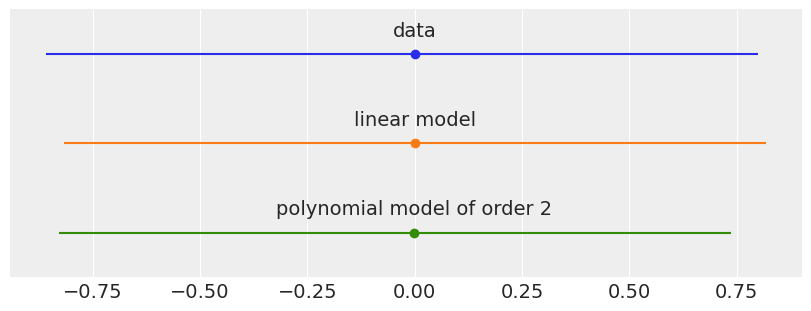

In [33]:
plt.figure(figsize=(8,3))
data = [y_1s,y_l,y_p]
labels = ['data','linear model','polynomial model of order {}'.format(order)]

for i,d in enumerate(data):
    mean= d.mean()
    err = np.percentile(d,[25,75])
    plt.errorbar(mean,-i,xerr=[[-err[0]],[err[1]]],fmt='o')
    plt.text(mean,-i+0.2,labels[i],ha='center',fontsize=14)

plt.ylim([-i-0.5,0.5])
plt.yticks([])
plt.savefig('dummy_model_comparison_forest.png',dpi=300)


### Takeaway
 * This comparison shows that the linear model is a good fit for the data end of the graph
 * This comparison shows that the polynomial model is a good fit for the data at the begining and middle of the graph
 * However, This comparison is confusing and does not lead to a certain conclusion
 * This focuses on why a correct comparison is needed to identify the better fit for the data

## Plotting the Dispersion of Both the Mean and the Interquartile Range

e:\Anaconda\envs\pm3bap\lib\site-packages\arviz\utils.py:175: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


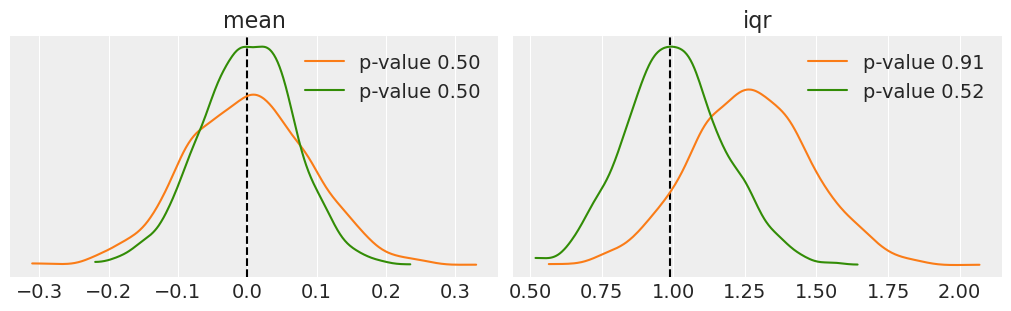

In [35]:
fig,ax = plt.subplots(1,2,figsize=(10,3),constrained_layout=True)

def iqr(x,a=0):
    return np.subtract(*np.percentile(x,[60,20],axis=a))

for idx, func in enumerate([np.mean,iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs,0,1,color='k',ls='--')
    for d_sim,c in zip([y_l,y_p],['C1','C2']):
        T_sim = func(d_sim,1)
        p_value = np.mean(T_sim>=T_obs)
        az.plot_kde(T_sim,plot_kwargs={'color':c},label=f'p-value {p_value:.2f}',ax = ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()
plt.savefig('dummy_model_comparison_pvalue.png',dpi=300)


### Takeaway

* Polynomial Model
    - We can derive from the above figure that the green model (polynomial) is better for prediction
    - The polynomial model offers less biased prediction as the p-value suggests

* Linear Model
    - On the other hand, as the p-value of the linear model is high
    - This suggests that there is high bias in the posterior predictive distribution